In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.image as mpimg
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
train = '/kaggle/input/inaturalist-data-set/inaturalist_12K/train'
test = '/kaggle/input/inaturalist-data-set/inaturalist_12K/val'

In [3]:
classes = ['Amphibia','Animalia','Arachnida','Aves','Fungi',
           'Insecta','Mammalia','Mollusca','Plantae','Reptilia']
IMG_SIZE = (256,256)

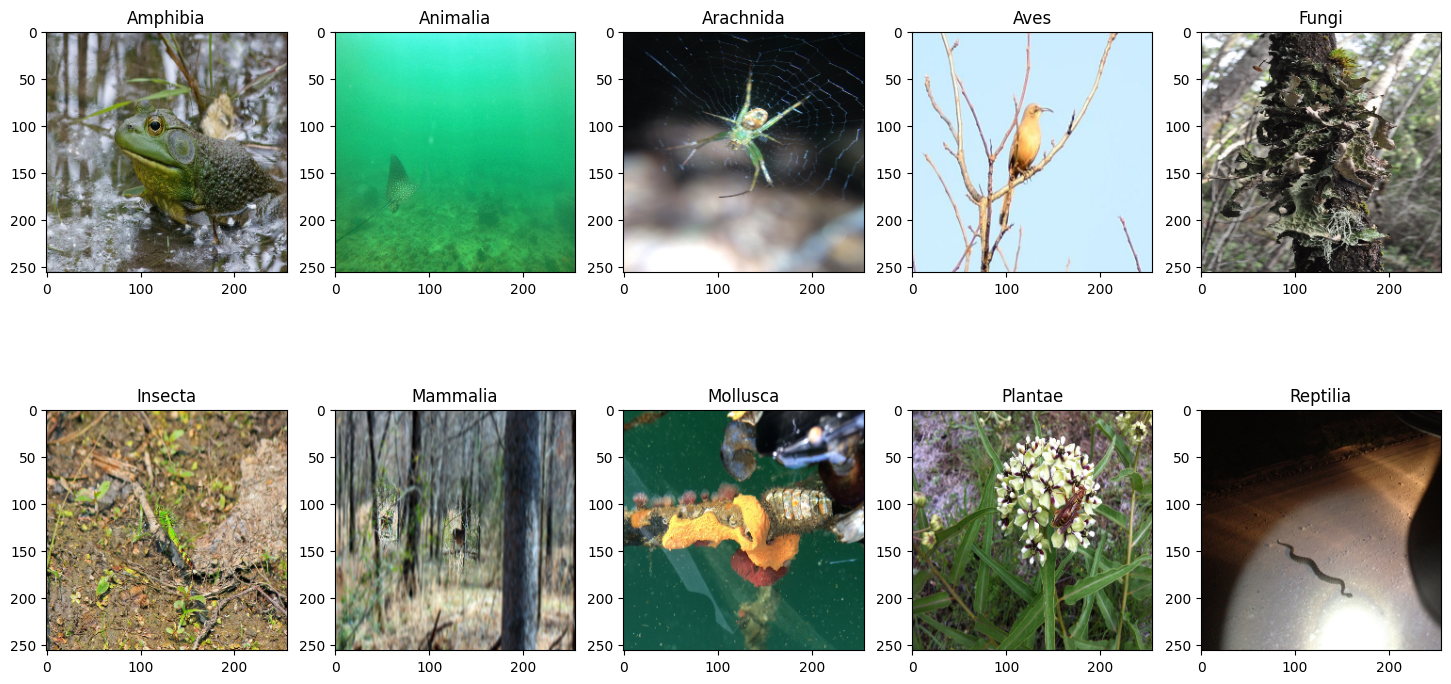

In [4]:
# visualization of each classes
fig = plt.figure(figsize=(18,9))
r, c = 2, 5
l = 1

for item in classes:
  loc = os.path.join(test, item)
  for img in os.listdir(loc):
    img_loc=(os.path.join(loc,img))
    img = mpimg.imread(img_loc)
    img = cv2.resize(img,IMG_SIZE)
    fig.add_subplot(r, c, l)
    plt.imshow(img)
    plt.title(item)
    l+=1
    break

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Training from scratch**

In [6]:
# Data preparation
from torchvision import transforms, datasets
train_dir = '/kaggle/input/inaturalist-data-set/inaturalist_12K/train'
test_dir = '/kaggle/input/inaturalist-data-set/inaturalist_12K/val'
IMG_SIZE = (224,224)

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize the images
    transforms.ToTensor(),        # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])  # Normalize the images


# Use ImageFolder to create a dataset
trainset = datasets.ImageFolder(root=train_dir, transform=transform)
val_size = int(0.2 * len(trainset))
train_size = len(trainset) - val_size
trainset, valset = random_split(trainset, [train_size, val_size])
testset = datasets.ImageFolder(root=test_dir, transform=transform)

In [7]:
class CNN(nn.Module):
    def __init__(self, trainset, valset, batch_size, num_filters,filter_org, kernel_size,
                 act_fn, num_neurons, batch_norm, dropout_rate):
        super().__init__()

        # DataLoader for the dataset
        self.dataloader_train = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
        self.dataloader_val = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle=True)
        #dataloader_test = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)
        self.batch_norm = batch_norm
        #num_layers = 5
        filters = []
        if filter_org=='same':
            filters = [num_filters]*5
        elif filter_org=='double':
            filters = [num_filters, num_filters*2, num_filters*4, num_filters*8, num_filters*16]
        elif filter_org=='half':
            filters = [num_filters, num_filters//2, num_filters//4, num_filters//8, num_filters//16]
        #Conv layer 1
        self.conv1 = nn.Conv2d(3, filters[0],
                               kernel_size=(kernel_size[0],kernel_size[0]),
                               stride=1, padding='same')
        #x = (256 - kernel_size[0] + 2)/1 + 1
        x = 224           # img size
        self.bn1 = nn.BatchNorm2d(filters[0])  # Batch Normalization

        if act_fn=='relu':          #nn.ReLU nn.GELU nn.SiLU nn.Mish nn.Tanh
          self.act1 = nn.ReLU()
        elif act_fn=='tanh':
          self.act1 = nn.Tanh()
        elif act_fn=='gelu':
          self.act1 = nn.GELU()
        elif act_fn=='silu':
          self.act1 = nn.SiLU()
        elif act_fn=='mish':
          self.act1 = nn.Mish()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.pool1 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 2
        self.conv2 = nn.Conv2d(filters[0], filters[1],
                               kernel_size=(kernel_size[1],kernel_size[1]),
                               stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(filters[1])

        if act_fn=='relu':
          self.act2 = nn.ReLU()
        elif act_fn=='tanh':
          self.act2 = nn.Tanh()
        elif act_fn=='gelu':
          self.act2 = nn.GELU()
        elif act_fn=='silu':
          self.act2 = nn.SiLU()
        elif act_fn=='mish':
          self.act2 = nn.Mish()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.pool2 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 3
        self.conv3 = nn.Conv2d(filters[1], filters[2],
                               kernel_size=(kernel_size[2],kernel_size[2]),
                               stride=1, padding='same')

        self.bn3 = nn.BatchNorm2d(filters[2])
        if act_fn=='relu':
          self.act3 = nn.ReLU()
        elif act_fn=='tanh':
          self.act3 = nn.Tanh()
        elif act_fn=='gelu':
          self.act3 = nn.GELU()
        elif act_fn=='silu':
          self.act3 = nn.SiLU()
        elif act_fn=='mish':
          self.act3 = nn.Mish()
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.pool3 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 4
        self.conv4 = nn.Conv2d(filters[2], filters[3],
                               kernel_size=(kernel_size[3],kernel_size[3]),
                               stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(filters[3])
        if act_fn=='relu':
          self.act4 = nn.ReLU()
        elif act_fn=='tanh':
          self.act4 = nn.Tanh()
        elif act_fn=='gelu':
          self.act4 = nn.GELU()
        elif act_fn=='silu':
          self.act4 = nn.SiLU()
        elif act_fn=='mish':
          self.act4 = nn.Mish()
        self.dropout4 = nn.Dropout(p=dropout_rate)
        self.pool4 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 5
        self.conv5 = nn.Conv2d(filters[3], filters[4],
                               kernel_size=(kernel_size[4],kernel_size[4]),
                               stride=1, padding='same')
        self.bn5 = nn.BatchNorm2d(filters[4])
        if act_fn=='relu':
          self.act5 = nn.ReLU()
        elif act_fn=='tanh':
          self.act5 = nn.Tanh()
        elif act_fn=='gelu':
          self.act5 = nn.GELU()
        elif act_fn=='silu':
          self.act5 = nn.SiLU()
        elif act_fn=='mish':
          self.act5 = nn.Mish()
        self.dropout5 = nn.Dropout(p=dropout_rate)
        self.pool5 = nn.MaxPool2d(2,2)
        x = x//2
        x = x*x*filters[4]
        #print(x)

        # Flatten
        self.flatten = nn.Flatten()

        # dense layer
        self.fc6 = nn.Linear(x, num_neurons)
        if act_fn=='relu':
          self.act6 = nn.ReLU()
        elif act_fn=='tanh':
          self.act6 = nn.Tanh()
        elif act_fn=='gelu':
          self.act6 = nn.GELU()
        elif act_fn=='silu':
          self.act6 = nn.SiLU()
        elif act_fn=='mish':
          self.act6 = nn.Mish()
        self.dropout6 = nn.Dropout(p=dropout_rate)
        # output layer
        self.fc7 = nn.Linear(num_neurons, 10)


    def forward(self, x):
        # input 3x128x128, output 32x128x128
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        # input 32x128x128, output 32x64x64
        x = self.pool1(x)

        # input 32x64x64, output 32x64x64
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        # input 32x64x64, output 32x32x32
        x = self.pool2(x)

        # input 32x32x32, output 64x32x32
        x = self.conv3(x)
        if self.batch_norm:
            x = self.bn3(x)
        x = self.act3(x)
        x = self.dropout3(x)
        # input 64x32x32, output 64x16x16
        x = self.pool3(x)

        # input 64x16x16, output 64x16x16
        x = self.conv4(x)
        if self.batch_norm:
            x = self.bn4(x)
        x = self.act4(x)
        x = self.dropout4(x)
        # input 64x16x16, output 64x8x8
        x = self.pool4(x)

        # input 64x8x8, output 128x8x8
        x = self.conv5(x)
        if self.batch_norm:
            x = self.bn5(x)
        x = self.act5(x)
        x = self.dropout5(x)
        # input 128x8x8, output 128x4x4
        x = self.pool5(x)

        # input 128,4,4 output 2048
        x = self.flatten(x)

        # input 2048, output 512
        x = self.act6(self.fc6(x))
        x = self.dropout6(x)

        # input 512, output 10
        x = self.fc7(x)
        return x

    def train(self, model, loss_fn, optimizer, n_epochs = 10):
        for epoch in range(n_epochs):
            train_accuracy = 0
            count = 0
            for inputs, labels in self.dataloader_train:
                # forward, backward, and then weight update
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                y_pred = model(inputs)
                loss = loss_fn(y_pred, labels)
                train_accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
                count += len(labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_accuracy /= count
            print("Epoch %d: model train accuracy %.2f%%" % (epoch, train_accuracy*100))
            wandb.log({ 'epoch': epoch, 'train_accuracy': train_accuracy * 100})
            # Clear cache after training epoch
            torch.cuda.empty_cache()
            val_accuracy = 0
            count = 0
            for inputs, labels in self.dataloader_val:
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_pred = model(inputs)
                val_loss = loss_fn(y_pred, labels)
                val_accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
                count += len(labels)
            val_accuracy /= count
            print("Epoch %d: model validation accuracy %.2f%%" % (epoch, val_accuracy*100))
            wandb.log({ 'epoch': epoch, 'validation_accuracy': val_accuracy * 100})
            wandb.log({ 'epoch': epoch, 'validation_loss': val_loss * 100})
            #Clear cache after validation
            torch.cuda.empty_cache()
        return model

In [8]:
!pip install wandb

In [9]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

key = input('Enter your API:')
wandb.login(key=key) #key="7836c2516a56fb9071600184ea90a0f6357f99dc"

Enter your API: 7836c2516a56fb9071600184ea90a0f6357f99dc


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tentuvenkatesh2 (tentuvenkatesh2-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
# sweep config file
sweep_config = {
    'method': 'bayes',
    'name' : 'bayes sweep_l23',
    'metric': {
      'goal': 'maximize',
      'name': 'validation_accuracy'
    },
    'parameters': {
        'filters_num':{
            'values': [16, 32, 64]
        },
        'filter_org':{
          'values': ['same', 'double', 'half']
        },
        'act_fn': {
            'values': ['relu', 'gelu', 'silu', 'mish', 'tanh']
        },
        'data_aug':{
            'values': [False]
        },
        'batch_norm':{
            'values': [True, False]
        },
        'dropout': {
            'values': [0, 0.2, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'l2_reg':{
            'values': [0, 0.0005, 0.05]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'kernel_size':{
            'values': [[3]*5, [3, 5, 5, 7, 7], [5]*5, [7, 5, 5, 3, 3] ]
        },
        'num_neurons_dense':{
            'values': [64, 128, 256]
        },
        'epochs':{
            'values': [6]
        }
    }
}

In [11]:
# Create a sweep
sweep_id = wandb.sweep(sweep = sweep_config, project='DA6401_AS2')

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

def main():
    torch.cuda.empty_cache()
    with wandb.init() as run:
        run_name = "-f_num_"+str(wandb.config.filters_num)+"-f_num_"+wandb.config.filter_org+"-ac_fn_"+wandb.config.act_fn+\
                    "-b_norm_"+str(wandb.config.batch_norm) + "-bs_"+str(wandb.config.batch_size) +"-neu_num"+str(wandb.config.num_neurons_dense)
        wandb.run.name = run_name
        
        # Check if kernel_size is an integer and convert it to a list if needed
        if isinstance(wandb.config.kernel_size, int):
            kernel_size = [wandb.config.kernel_size] * 5  # Create a list of 5 identical values
        else:
            kernel_size = wandb.config.kernel_size
        
        model = CNN(trainset, valset, batch_size=wandb.config.batch_size, num_filters=wandb.config.filters_num,
                    filter_org=wandb.config.filter_org, kernel_size=kernel_size, act_fn=wandb.config.act_fn,
                    num_neurons=wandb.config.num_neurons_dense, batch_norm=wandb.config.batch_norm, dropout_rate=wandb.config.dropout)
        model.to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.l2_reg)
        model.train(model, loss_fn, optimizer, n_epochs=6)
        torch.cuda.empty_cache()
wandb.agent(sweep_id, function = main, count = 20) # calls main function for count number of times
wandb.finish()
torch.cuda.empty_cache()

Create sweep with ID: fummb006
Sweep URL: https://wandb.ai/tentuvenkatesh2-indian-institute-of-technology-madras/DA6401_AS2/sweeps/fummb006


wandb: Agent Starting Run: 8sb7pkbx with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 0: model train accuracy 25.68%
Epoch 0: model validation accuracy 31.97%
Epoch 1: model train accuracy 33.10%
Epoch 1: model validation accuracy 34.12%
Epoch 2: model train accuracy 35.64%
Epoch 2: model validation accuracy 34.67%
Epoch 3: model train accuracy 39.33%
Epoch 3: model validation accuracy 37.32%
Epoch 4: model train accuracy 43.14%
Epoch 4: model validation accuracy 39.82%
Epoch 5: model train accuracy 46.91%
Epoch 5: model validation accuracy 39.47%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▄▅▇█
validation_accuracy,▁▃▃▆██
validation_loss,▄▆█▅▁█
epoch,5
train_accuracy,46.9125
validation_accuracy,39.46974
validation_loss,237.25519


wandb: Agent Starting Run: e71ym4px with config:
wandb: 	act_fn: tanh
wandb: 	batch_norm: True
wandb: 	batch_size: 16
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 16
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	l2_reg: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 64


Epoch 0: model train accuracy 20.13%
Epoch 0: model validation accuracy 24.06%
Epoch 1: model train accuracy 25.09%
Epoch 1: model validation accuracy 26.91%
Epoch 2: model train accuracy 27.00%
Epoch 2: model validation accuracy 29.21%
Epoch 3: model train accuracy 27.79%
Epoch 3: model validation accuracy 28.91%
Epoch 4: model train accuracy 28.73%
Epoch 4: model validation accuracy 30.62%
Epoch 5: model train accuracy 29.06%
Epoch 5: model validation accuracy 30.42%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▅▆▇██
validation_accuracy,▁▄▇▆██
validation_loss,▅█▁▂▂█
epoch,5
train_accuracy,29.0625
validation_accuracy,30.41521
validation_loss,236.16516


wandb: Agent Starting Run: 3d76b2z7 with config:
wandb: 	act_fn: gelu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 16
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	l2_reg: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 64


Epoch 0: model train accuracy 10.11%
Epoch 0: model validation accuracy 8.90%
Epoch 1: model train accuracy 10.28%
Epoch 1: model validation accuracy 8.90%
Epoch 2: model train accuracy 10.28%
Epoch 2: model validation accuracy 8.90%
Epoch 3: model train accuracy 10.28%
Epoch 3: model validation accuracy 8.90%
Epoch 4: model train accuracy 10.28%
Epoch 4: model validation accuracy 8.90%
Epoch 5: model train accuracy 10.28%
Epoch 5: model validation accuracy 8.90%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁█████
validation_accuracy,▁▁▁▁▁▁
validation_loss,█▅▁█▁▄
epoch,5
train_accuracy,10.275
validation_accuracy,8.90445
validation_loss,229.98831


wandb: Agent Starting Run: tw7g7pg7 with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: half
wandb: 	filters_num: 32
wandb: 	kernel_size: [7, 5, 5, 3, 3]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 16.59%
Epoch 0: model validation accuracy 19.26%
Epoch 1: model train accuracy 21.15%
Epoch 1: model validation accuracy 21.51%
Epoch 2: model train accuracy 24.10%
Epoch 2: model validation accuracy 25.61%
Epoch 3: model train accuracy 26.20%
Epoch 3: model validation accuracy 26.41%
Epoch 4: model train accuracy 28.04%
Epoch 4: model validation accuracy 25.41%
Epoch 5: model train accuracy 28.58%
Epoch 5: model validation accuracy 27.06%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▄▅▇██
validation_accuracy,▁▃▇▇▇█
validation_loss,▇▆▆█▁▄
epoch,5
train_accuracy,28.575
validation_accuracy,27.06353
validation_loss,209.08229


wandb: Agent Starting Run: u2m2a5ck with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	filter_org: half
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 16.31%
Epoch 0: model validation accuracy 21.51%
Epoch 1: model train accuracy 24.06%
Epoch 1: model validation accuracy 26.21%
Epoch 2: model train accuracy 27.53%
Epoch 2: model validation accuracy 29.61%
Epoch 3: model train accuracy 29.70%
Epoch 3: model validation accuracy 28.96%
Epoch 4: model train accuracy 31.90%
Epoch 4: model validation accuracy 30.02%
Epoch 5: model train accuracy 32.44%
Epoch 5: model validation accuracy 31.22%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▄▆▇██
validation_accuracy,▁▄▇▆▇█
validation_loss,█▅▅▄▁▁
epoch,5
train_accuracy,32.4375
validation_accuracy,31.21561
validation_loss,161.95151


wandb: Agent Starting Run: qzw8hdpm with config:
wandb: 	act_fn: gelu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0.5
wandb: 	epochs: 6
wandb: 	filter_org: half
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 12.31%
Epoch 0: model validation accuracy 15.06%
Epoch 1: model train accuracy 14.98%
Epoch 1: model validation accuracy 16.06%
Epoch 2: model train accuracy 16.99%
Epoch 2: model validation accuracy 16.96%
Epoch 3: model train accuracy 18.08%
Epoch 3: model validation accuracy 17.36%
Epoch 4: model train accuracy 19.25%
Epoch 4: model validation accuracy 18.81%
Epoch 5: model train accuracy 21.20%
Epoch 5: model validation accuracy 20.71%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▅▆▆█
validation_accuracy,▁▂▃▄▆█
validation_loss,▄▅▁█▇▃
epoch,5
train_accuracy,21.2
validation_accuracy,20.71036
validation_loss,215.91043


wandb: Agent Starting Run: 2v8cvq8u with config:
wandb: 	act_fn: silu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	l2_reg: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 19.81%
Epoch 0: model validation accuracy 20.26%
Epoch 1: model train accuracy 22.35%
Epoch 1: model validation accuracy 22.76%
Epoch 2: model train accuracy 23.20%
Epoch 2: model validation accuracy 24.86%
Epoch 3: model train accuracy 24.44%
Epoch 3: model validation accuracy 27.66%
Epoch 4: model train accuracy 24.85%
Epoch 4: model validation accuracy 22.11%
Epoch 5: model train accuracy 25.44%
Epoch 5: model validation accuracy 23.31%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▄▅▇▇█
validation_accuracy,▁▃▅█▃▄
validation_loss,█▇█▁▄▄
epoch,5
train_accuracy,25.4375
validation_accuracy,23.31166
validation_loss,205.47662


wandb: Agent Starting Run: cm9gnbvd with config:
wandb: 	act_fn: silu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 19.11%
Epoch 0: model validation accuracy 25.06%
Epoch 1: model train accuracy 25.53%
Epoch 1: model validation accuracy 26.71%
Epoch 2: model train accuracy 29.06%
Epoch 2: model validation accuracy 29.36%
Epoch 3: model train accuracy 30.44%
Epoch 3: model validation accuracy 30.62%
Epoch 4: model train accuracy 33.89%
Epoch 4: model validation accuracy 31.72%
Epoch 5: model train accuracy 36.99%
Epoch 5: model validation accuracy 36.02%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▄▅▅▇█
validation_accuracy,▁▂▄▅▅█
validation_loss,▇▇▇█▆▁
epoch,5
train_accuracy,36.9875
validation_accuracy,36.01801
validation_loss,135.79974


wandb: Agent Starting Run: kqiij8fn with config:
wandb: 	act_fn: gelu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 24.50%
Epoch 0: model validation accuracy 30.27%
Epoch 1: model train accuracy 30.13%
Epoch 1: model validation accuracy 31.52%
Epoch 2: model train accuracy 33.83%
Epoch 2: model validation accuracy 33.22%
Epoch 3: model train accuracy 36.24%
Epoch 3: model validation accuracy 35.57%
Epoch 4: model train accuracy 39.45%
Epoch 4: model validation accuracy 38.37%
Epoch 5: model train accuracy 41.90%
Epoch 5: model validation accuracy 39.12%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▅▆▇█
validation_accuracy,▁▂▃▅▇█
validation_loss,█▅▇▅▁▅
epoch,5
train_accuracy,41.9
validation_accuracy,39.11956
validation_loss,180.25356


wandb: Agent Starting Run: pqaxvtmf with config:
wandb: 	act_fn: gelu
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 19.00%
Epoch 0: model validation accuracy 22.86%
Epoch 1: model train accuracy 26.18%
Epoch 1: model validation accuracy 27.51%
Epoch 2: model train accuracy 30.66%
Epoch 2: model validation accuracy 32.77%
Epoch 3: model train accuracy 34.01%
Epoch 3: model validation accuracy 34.67%
Epoch 4: model train accuracy 37.76%
Epoch 4: model validation accuracy 33.52%
Epoch 5: model train accuracy 41.75%
Epoch 5: model validation accuracy 36.47%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▅▆▇█
validation_accuracy,▁▃▆▇▆█
validation_loss,▆▅▇▁▃█
epoch,5
train_accuracy,41.75
validation_accuracy,36.46824
validation_loss,202.41098


wandb: Agent Starting Run: qzt9xmul with config:
wandb: 	act_fn: gelu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 19.51%
Epoch 0: model validation accuracy 25.46%
Epoch 1: model train accuracy 27.50%
Epoch 1: model validation accuracy 30.02%
Epoch 2: model train accuracy 32.08%
Epoch 2: model validation accuracy 32.27%
Epoch 3: model train accuracy 36.95%
Epoch 3: model validation accuracy 34.07%
Epoch 4: model train accuracy 42.64%
Epoch 4: model validation accuracy 35.42%
Epoch 5: model train accuracy 50.81%
Epoch 5: model validation accuracy 35.57%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▄▅▆█
validation_accuracy,▁▄▆▇██
validation_loss,▆▅█▁▄▄
epoch,5
train_accuracy,50.8125
validation_accuracy,35.56778
validation_loss,173.90216


wandb: Agent Starting Run: tcyux02w with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: half
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 18.11%
Epoch 0: model validation accuracy 23.61%
Epoch 1: model train accuracy 25.61%
Epoch 1: model validation accuracy 27.26%
Epoch 2: model train accuracy 28.38%
Epoch 2: model validation accuracy 27.86%
Epoch 3: model train accuracy 29.81%
Epoch 3: model validation accuracy 29.96%
Epoch 4: model train accuracy 31.61%
Epoch 4: model validation accuracy 28.96%
Epoch 5: model train accuracy 33.01%
Epoch 5: model validation accuracy 30.02%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▅▆▆▇█
validation_accuracy,▁▅▆█▇█
validation_loss,█▆▃▂▁▁
epoch,5
train_accuracy,33.0125
validation_accuracy,30.01501
validation_loss,178.79887


wandb: Agent Starting Run: d8aowipe with config:
wandb: 	act_fn: silu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 21.12%
Epoch 0: model validation accuracy 29.16%
Epoch 1: model train accuracy 29.75%
Epoch 1: model validation accuracy 30.52%
Epoch 2: model train accuracy 32.80%
Epoch 2: model validation accuracy 32.52%
Epoch 3: model train accuracy 34.86%
Epoch 3: model validation accuracy 34.62%
Epoch 4: model train accuracy 38.01%
Epoch 4: model validation accuracy 34.17%
Epoch 5: model train accuracy 41.64%
Epoch 5: model validation accuracy 35.92%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▄▅▆▇█
validation_accuracy,▁▂▄▇▆█
validation_loss,▅▃█▆▃▁
epoch,5
train_accuracy,41.6375
validation_accuracy,35.91796
validation_loss,169.89655


wandb: Agent Starting Run: jwsmfiji with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 24.38%
Epoch 0: model validation accuracy 27.86%
Epoch 1: model train accuracy 31.30%
Epoch 1: model validation accuracy 32.72%
Epoch 2: model train accuracy 33.74%
Epoch 2: model validation accuracy 33.52%
Epoch 3: model train accuracy 36.20%
Epoch 3: model validation accuracy 36.92%
Epoch 4: model train accuracy 38.09%
Epoch 4: model validation accuracy 36.87%
Epoch 5: model train accuracy 39.86%
Epoch 5: model validation accuracy 38.42%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▄▅▆▇█
validation_accuracy,▁▄▅▇▇█
validation_loss,▄▆█▅█▁
epoch,5
train_accuracy,39.8625
validation_accuracy,38.41921
validation_loss,148.11513


wandb: Agent Starting Run: 4gcjy7of with config:
wandb: 	act_fn: gelu
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 10.05%
Epoch 0: model validation accuracy 10.36%
Epoch 1: model train accuracy 9.90%
Epoch 1: model validation accuracy 10.36%
Epoch 2: model train accuracy 9.90%
Epoch 2: model validation accuracy 10.36%
Epoch 3: model train accuracy 9.90%
Epoch 3: model validation accuracy 10.36%
Epoch 4: model train accuracy 9.90%
Epoch 4: model validation accuracy 10.36%
Epoch 5: model train accuracy 9.90%
Epoch 5: model validation accuracy 10.36%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,█▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁
validation_loss,▆▁▅█▅▄
epoch,5
train_accuracy,9.9
validation_accuracy,10.35518
validation_loss,230.2583


wandb: Agent Starting Run: 0nnsdwf2 with config:
wandb: 	act_fn: gelu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 13.89%
Epoch 0: model validation accuracy 13.26%
Epoch 1: model train accuracy 13.18%
Epoch 1: model validation accuracy 13.71%
Epoch 2: model train accuracy 14.96%
Epoch 2: model validation accuracy 16.71%
Epoch 3: model train accuracy 16.46%
Epoch 3: model validation accuracy 16.31%
Epoch 4: model train accuracy 18.02%
Epoch 4: model validation accuracy 15.26%
Epoch 5: model train accuracy 17.63%
Epoch 5: model validation accuracy 16.61%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▂▁▄▆█▇
validation_accuracy,▁▂█▇▅█
validation_loss,▃█▃▁▁▁
epoch,5
train_accuracy,17.625
validation_accuracy,16.6083
validation_loss,221.14337


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j9o85305 with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 18.86%
Epoch 0: model validation accuracy 23.01%
Epoch 1: model train accuracy 25.38%
Epoch 1: model validation accuracy 26.71%
Epoch 2: model train accuracy 29.21%
Epoch 2: model validation accuracy 33.07%
Epoch 3: model train accuracy 32.99%
Epoch 3: model validation accuracy 33.87%
Epoch 4: model train accuracy 35.89%
Epoch 4: model validation accuracy 34.37%
Epoch 5: model train accuracy 39.46%
Epoch 5: model validation accuracy 38.52%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▅▆▇█
validation_accuracy,▁▃▆▆▆█
validation_loss,█▅▃▁█▂
epoch,5
train_accuracy,39.4625
validation_accuracy,38.51926
validation_loss,166.78616


wandb: Agent Starting Run: 76nxibdp with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: same
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 128


Epoch 0: model train accuracy 16.93%
Epoch 0: model validation accuracy 22.41%
Epoch 1: model train accuracy 24.10%
Epoch 1: model validation accuracy 26.76%
Epoch 2: model train accuracy 27.24%
Epoch 2: model validation accuracy 28.06%
Epoch 3: model train accuracy 28.73%
Epoch 3: model validation accuracy 30.17%
Epoch 4: model train accuracy 31.14%
Epoch 4: model validation accuracy 31.02%
Epoch 5: model train accuracy 33.01%
Epoch 5: model validation accuracy 32.37%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▄▅▆▇█
validation_accuracy,▁▄▅▆▇█
validation_loss,▇▇▇▁█▅
epoch,5
train_accuracy,33.0125
validation_accuracy,32.36618
validation_loss,200.74696


wandb: Agent Starting Run: 0dph8xr3 with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 19.11%
Epoch 0: model validation accuracy 20.61%
Epoch 1: model train accuracy 22.03%
Epoch 1: model validation accuracy 23.46%
Epoch 2: model train accuracy 24.53%
Epoch 2: model validation accuracy 26.66%
Epoch 3: model train accuracy 25.93%
Epoch 3: model validation accuracy 26.56%
Epoch 4: model train accuracy 27.50%
Epoch 4: model validation accuracy 26.91%
Epoch 5: model train accuracy 29.26%
Epoch 5: model validation accuracy 29.11%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▅▆▇█
validation_accuracy,▁▃▆▆▆█
validation_loss,▅▇▂▆█▁
epoch,5
train_accuracy,29.2625
validation_accuracy,29.11456
validation_loss,176.51443


wandb: Agent Starting Run: si4vv5rd with config:
wandb: 	act_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	epochs: 6
wandb: 	filter_org: double
wandb: 	filters_num: 64
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	num_neurons_dense: 256


Epoch 0: model train accuracy 25.55%
Epoch 0: model validation accuracy 32.07%
Epoch 1: model train accuracy 32.23%
Epoch 1: model validation accuracy 34.07%
Epoch 2: model train accuracy 34.71%
Epoch 2: model validation accuracy 34.12%
Epoch 3: model train accuracy 39.44%
Epoch 3: model validation accuracy 37.72%
Epoch 4: model train accuracy 42.78%
Epoch 4: model validation accuracy 38.02%
Epoch 5: model train accuracy 45.89%
Epoch 5: model validation accuracy 38.27%


epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
train_accuracy,▁▃▄▆▇█
validation_accuracy,▁▃▃▇██
validation_loss,▁▇▇▃█▄
epoch,5
train_accuracy,45.8875
validation_accuracy,38.26913
validation_loss,183.82236
